## 00. Load & Visualize MNIST Dataset

In [1]:
import os
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..\\..\\data\\MNIST'))

hyperparams = {
    "batch_size": 64,
    "learning_rate": 0.1,
    "hidden_size": 300,
    "epochs": 20
}

In [2]:
import numpy as np

class MNISTDataset():
    def __init__(self, path_to_images: os.PathLike, path_to_labels: os.PathLike):
        with open(path_to_images, 'rb') as f:
            self.images = np.frombuffer(f.read(), np.uint8, offset=16)
            self.images = self.images.reshape(-1, 28*28)
            self.images = self.images / 255.0

        with open(path_to_labels, 'rb') as f:
            self.labels = np.frombuffer(f.read(), np.uint8, offset=8)

train_dataset = MNISTDataset(path_to_images=os.path.join(DATA_PATH, 'train-images.idx3-ubyte'),
                             path_to_labels=os.path.join(DATA_PATH, 'train-labels.idx1-ubyte'))

test_dataset = MNISTDataset(path_to_images=os.path.join(DATA_PATH, 't10k-images.idx3-ubyte'),
                             path_to_labels=os.path.join(DATA_PATH, 't10k-labels.idx1-ubyte'))
train_dataset.images.shape, test_dataset.images.shape

((60000, 784), (10000, 784))

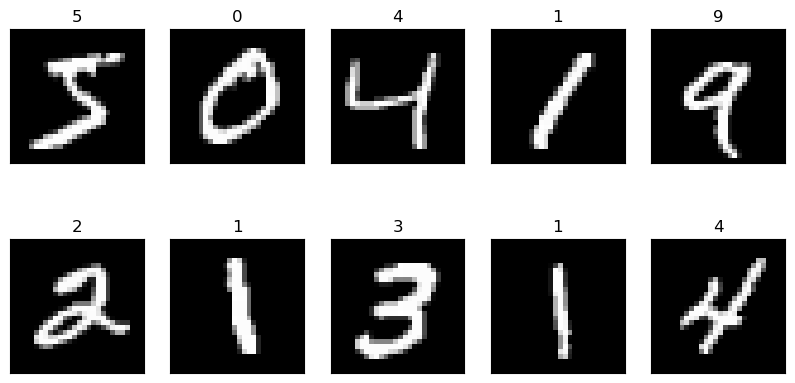

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10,5))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

for i, ax in enumerate(fig.axes):
    ax.imshow(train_dataset.images[i].reshape(28, 28), cmap="grey")
    ax.set_title(train_dataset.labels[i])

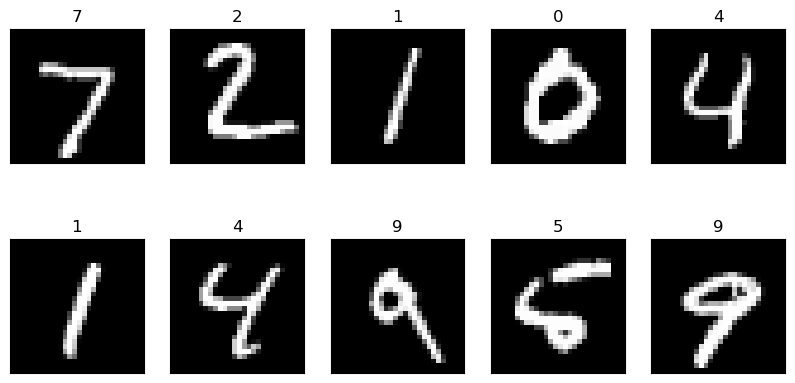

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10,5))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

for i, ax in enumerate(fig.axes):
    ax.imshow(test_dataset.images[i].reshape(28, 28), cmap="grey")
    ax.set_title(test_dataset.labels[i])

## 01. Data Loader & Model

In [5]:
class DataLoader():
    def __init__(self, dataset : MNISTDataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_batches = len(self.dataset.images) // self.batch_size

    def __iter__(self):
        indices = np.arange(len(self.dataset.images))
        if self.shuffle:
            np.random.shuffle(indices)
        for i in range(self.num_batches):
            batch_indices = indices[i*self.batch_size:(i+1)*self.batch_size]
            batch_images = self.dataset.images[batch_indices]
            batch_labels = self.dataset.labels[batch_indices]
            yield batch_images, batch_labels

        if len(self.dataset.images) % self.batch_size != 0:
            batch_indices = indices[self.num_batches*self.batch_size:]
            batch_images = self.dataset.images[batch_indices]
            batch_labels = self.dataset.labels[batch_indices]
            yield batch_images, batch_labels
    
    def __len__(self):
        return self.num_batches
    
train_data_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True)

In [6]:
# Helper functions

def to_one_hot_encoding(labels, num_classes=10):
    one_hot_labels = np.zeros((len(labels), num_classes))
    one_hot_labels[np.arange(len(labels)), labels] = 1.0
    return one_hot_labels

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    for images, labels in data_loader:
        outputs = model.forward(images)

        predicted = np.argmax(outputs, axis=1)
        
        n += len(labels)
        tp += (predicted == labels).sum()
    return tp / n

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=-1, keepdims=True)

def cross_entropy_loss(outputs, targets):
    outputs = np.clip(outputs, 1e-12, 1. - 1e-12)
    return -np.sum(targets * np.log(outputs+1e-9)) / targets.shape[0]

Some backpropagation formulas:
$$
\frac{\partial L}{\partial z_2} = y - \hat{y}
$$

$$
\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial z_2} \times \frac{\partial z_2}{\partial a_1} \times \frac{\partial a_1}{\partial z_1}, where\space a_1\space=\space relu(z_1)
$$

In [7]:
class FCNN():
    def __init__(self, hidden_size=300):
        self.weights1 = np.random.randn(784, hidden_size) * np.sqrt(2.0/784)
        self.weights2 = np.random.randn(hidden_size, 10) * np.sqrt(2.0/hidden_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, 10))

    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = softmax(self.z2)
        return self.a2
    
    def backward(self, inputs, outputs, targets, lr=0.1):
        dL_dz2 = outputs - to_one_hot_encoding(targets) # (64, 10) = (batch_size, num_classes)
        dL_dz2 = dL_dz2 / outputs.shape[0]

        dL_dw2 = np.dot(self.a1.T, dL_dz2) # (64, 300).T x (64, 10) = (300, 10)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True) # (1, 10)

        dL_da1 = np.dot(dL_dz2, self.weights2.T) # (64, 10) x (300, 10).T = (64, 300)
        dL_dz1 = dL_da1 * drelu(self.z1) # (64, 300) * (64, 300)

        dL_dw1 = np.dot(inputs.T, dL_dz1) # (64, 784).T x (64, 300) = (784, 300)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True) # (1, 300)

        self.weights1 -= lr * dL_dw1
        self.bias1 -= lr * dL_db1
        self.weights2 -= lr * dL_dw2
        self.bias2 -= lr * dL_db2

## 02. Training Loop & Evaluation

In [10]:
import time

model = FCNN(hidden_size=hyperparams["hidden_size"])
epochs = hyperparams["epochs"]

for epoch in range(epochs):
    train_loss = 0
    start_time = time.time()
    for i, (inputs, targets) in enumerate(train_data_loader):
        outputs = model.forward(inputs)

        loss = cross_entropy_loss(outputs, to_one_hot_encoding(targets))
        train_loss += loss

        model.backward(inputs, outputs, targets, lr=hyperparams["learning_rate"])
    end_time = time.time()

    print(f"epoch {epoch + 1}/{epochs}: loss = {train_loss / len(train_data_loader):.3f}, accuracy = {get_accuracy(train_data_loader, model):.3f}, {end_time - start_time:.3f}sec")

epoch 1/20: loss = 0.349, accuracy = 0.931, 2.027sec
epoch 2/20: loss = 0.186, accuracy = 0.959, 2.047sec
epoch 3/20: loss = 0.137, accuracy = 0.969, 1.966sec
epoch 4/20: loss = 0.110, accuracy = 0.974, 2.090sec
epoch 5/20: loss = 0.092, accuracy = 0.977, 2.117sec
epoch 6/20: loss = 0.078, accuracy = 0.982, 2.064sec
epoch 7/20: loss = 0.068, accuracy = 0.981, 2.099sec
epoch 8/20: loss = 0.060, accuracy = 0.987, 2.080sec
epoch 9/20: loss = 0.053, accuracy = 0.988, 2.139sec
epoch 10/20: loss = 0.047, accuracy = 0.989, 2.291sec
epoch 11/20: loss = 0.043, accuracy = 0.992, 2.189sec
epoch 12/20: loss = 0.039, accuracy = 0.993, 2.293sec
epoch 13/20: loss = 0.035, accuracy = 0.993, 2.108sec
epoch 14/20: loss = 0.032, accuracy = 0.994, 2.197sec
epoch 15/20: loss = 0.029, accuracy = 0.995, 2.138sec
epoch 16/20: loss = 0.026, accuracy = 0.995, 2.099sec
epoch 17/20: loss = 0.024, accuracy = 0.996, 2.251sec
epoch 18/20: loss = 0.022, accuracy = 0.997, 2.293sec
epoch 19/20: loss = 0.020, accuracy =

In [11]:
f"test accuracy = {get_accuracy(test_data_loader, model):.3f}"

'test accuracy = 0.981'